In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage,ToolMessage, BaseMessage
from utils import available_pdfs
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import BaseTool, tool
from langgraph.prebuilt import ToolNode
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [3]:
@tool
def select_pdf(pdfs_in_query: list) -> list:
    """Select PDFs from a list based on user query.
    This tool helps find and select PDF documents that match the user's query 
    based on title, content description, or other metadata.

    Args:
        pdfs_in_query (list): List of PDF names mentioned in the user query

    Returns:
        list: List of selected PDF documents matching the query, with their metadata.
            Returns empty list if no matches found.
    """
    available_pdfs = available_pdfs()
    print(f"Available PDFs: {available_pdfs}")
    
    if not pdfs_in_query:
        return available_pdfs
    
    selected_pdfs = []

    for pdf in pdfs_in_query:
        if pdf.lower() in available_pdfs:
            selected_pdfs.append(pdf)

    return selected_pdfs

In [4]:
tools = [
    select_pdf,
]

In [ ]:
llm = ChatGroq.bind_tools(tools)

In [6]:
from pydantic import BaseModel, Field
from typing import Literal

class Parser(BaseModel):
    """LLM will be allowed to output only 'summarization' or 'rag' based on the user query."""
    query: Literal["summarization", "rag"]

def orchestrator(state: State) -> State:
    """Router function to determine the next step in the state graph.
    This function checks the current state and decides which tool or action to take next.

    Args:
        state (State): The current state of the graph.

    Returns:
        State: The updated state after processing the current step.
    """
    user_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    
    prompt = PromptTemplate(template = """
        You are a decision-making agent. Choose one of the following processes based on the user query:

        <summarization> — Select this only if the user requests a summary of the entire PDF.

        <rag> — Select this for any other type of query, including questions about specific sections, topic, paragraph or content from the PDF.

        Respond with only <summarization> or <rag> based on the input:

        Input: {user_input}
        """,
        input_variables=["user_input"]
    )
    
    structured_llm = llm.with_structured_output(Parser)
    
    chain = prompt | structured_llm

    response = chain.invoke({"user_input": user_message.content})
    
    route_message = SystemMessage(content=f"Query classified as: {response.query}")
    
    return {"messages": state["messages"] + [route_message]}

In [7]:
memory = MemorySaver()

graph = StateGraph(State)

graph.add_node("router",orchestrator)

graph.add_edge(START, "router")
graph.add_edge("router", END)

app = graph.compile(checkpointer=memory)

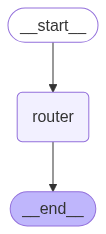

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "1"}}

while True:
    try:
        user_input = input("User: ")
        
        if user_input.lower() in ["exit", "quit", "stop"]:
            break
        events = app.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        )
        for event in events:
            event["messages"][-1].pretty_print()
    except Exception as e:
        print(f"An error occurred: {e}")
        break

================================ Human Message =================================

i want you summarize the pdf
An error occurred: Invalid argument provided to Gemini: 400 Function calling is not enabled for models/gemma-3-27b-it
